In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from core.generator import weekly
from core.model import Hierarchy

%matplotlib qt

In [2]:
stock    = '0001.HK'
data_dir = './data/processed'
lexicon  = 'SenticNet5'
split    = 0.8

YCOL = ['pct_chg']

In [3]:
indicator = pd.read_csv(os.path.join(data_dir, 'indicators', '%s.csv' % stock), index_col='date', parse_dates=True)
sentiment = pd.read_csv(os.path.join(data_dir, 'sentiments', lexicon, '%s.csv' % stock), index_col='date', parse_dates=True)
data      = pd.merge(indicator, sentiment, how='left', left_index=True, right_index=True)
data      = data.drop(['open', 'high', 'low', 'adj close'], axis=1)
data      = data.fillna(0)
data

,close,volume,ma7,ma14,ma21,pct_chg,upper,mid,lower,adx,...,inhpase,quadrature,sine,leadsine,trendmode,polarity,pleasantness,attention,sensitivity,aptitude
date,,,,,,,,,,,,,,,,,,,,,
2003-04-03,42.80,7906900,44.01429,45.10000,45.12381,-2.05950,44.84599,43.54,42.23401,19.63993,...,-1.81836,-0.75161,-0.99992,-0.69787,1,0.26852,-0.06965,0.36093,-0.04510,0.29688
2003-04-04,44.10,7601200,43.78571,45.12143,44.96190,3.03738,44.32686,43.42,42.51314,19.80534,...,-1.74026,-0.06861,-0.94176,-0.42813,1,0.26513,0.02843,0.17367,-0.00665,0.41081
2003-04-07,45.10,6543800,43.84286,45.13571,44.88571,2.26757,45.35571,43.82,42.28429,19.09246,...,-1.90128,-0.08068,-0.79391,-0.13143,1,0.29441,0.05087,0.33754,0.01065,0.16199
2003-04-08,44.40,7190100,43.80000,44.90714,44.85714,-1.55211,45.54525,44.02,42.49475,18.43050,...,-1.95259,1.29353,-0.39198,0.37335,0,0.24803,0.06883,0.32927,-0.04072,0.16143
2003-04-09,42.60,11624700,43.72857,44.52857,44.78095,-4.05405,45.71416,43.80,41.88584,19.02330,...,-0.93676,1.75621,-0.07812,0.64971,1,0.00763,-0.61105,0.33856,-0.16676,0.43990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-11,109.80,11700900,110.82857,113.30000,115.02857,3.68272,115.76080,109.76,103.75920,20.64984,...,-3.81804,-5.80393,-0.53596,0.21799,1,0.42812,0.28148,0.31179,0.07546,0.54213
2008-03-12,111.00,9031900,110.32857,113.03571,114.89048,1.09290,114.08358,109.22,104.35642,19.98822,...,-4.31154,-1.47933,-0.59801,0.14389,1,0.85050,0.34478,1.75549,0.64964,0.66897
2008-03-13,106.00,7283700,109.40000,112.60000,114.42857,-4.50450,112.10000,107.94,103.78000,19.94201,...,-3.77835,-1.06090,-0.41632,0.34854,1,0.01556,0.01233,0.02000,0.00000,0.01422


In [4]:
taus = np.arange(1, 8)
n_class = np.arange(2, 10)

scores = list()
for tau in taus:
    score = list()
    X = np.array([x.mean().values for x in weekly(data, tau)])
    X = StandardScaler().fit_transform(X)
    for n in n_class:
        clster = Hierarchy(n, method='ward', criterion='maxclust').fit(X)
        score.append(clster.silhouette_score_)
    scores.append(score)
scores = np.array(scores).T
best_tau = taus[np.argmax(score) % len(taus)]
best_n   = n_class[np.argmax(score) // len(taus)]
print('get best cluster parameters: tau = %d, n = %d, score = %.3f' % (best_tau, best_n, scores.max()))

get best cluster parameters: tau = 1, n = 2, score = 0.214


In [5]:
fig = plt.figure()
ax = Axes3D(fig)
grid = np.meshgrid(taus, n_class)
ax.plot_surface(grid[0], grid[1], scores, cmap='rainbow')
ax.view_init(elev=25, azim=-135)
ax.set_xlabel('Period $\\tau$')
ax.set_ylabel('Style number $n$')
ax.set_zlabel('Silhouette score')
plt.show()

In [6]:
def class_change(X, y, center, radius, rank=1):
    change = abs(np.sign(np.append(0, np.diff(y,rank)))) # change[0] === 0
    dist = []
    for i in range(len(change)):
        if change[i] == 0:
            dist.append(0)
        else:
            precenter = center[y[i-rank]]
            preradius = radius[y[i-rank]]
            dist.append(abs((np.linalg.norm(X[i] - precenter) - preradius) / preradius))
    return dist

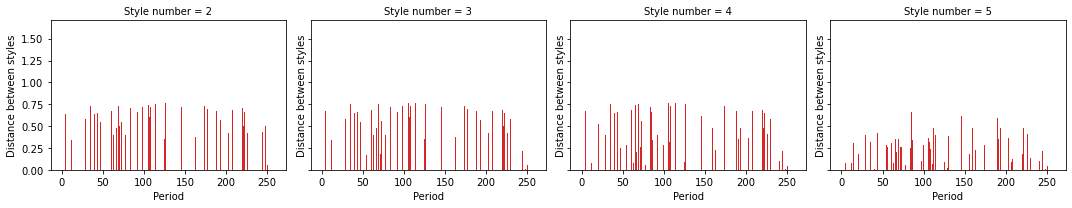

In [7]:
tau = best_tau
n_class = np.arange(2,6)

X = [x.mean().values for x in weekly(data, tau)]
X = StandardScaler().fit_transform(X)
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
for i, n in enumerate(n_class):
    cluster = Hierarchy(n, method='ward', criterion='maxclust').fit(X)
    dist = class_change(X, cluster.predict(), cluster.center, cluster.radius)
    ax[i].bar(np.arange(len(dist)), dist, color='C3')
    ax[i].set_xlabel('Period', fontsize=10)
    ax[i].set_ylabel('Distance between styles', fontsize=10)
    ax[i].set_title('Style number = %d' % n, fontsize=10)
plt.tight_layout()
plt.show()

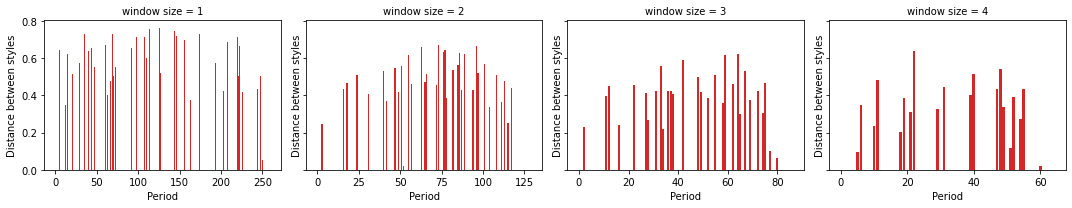

In [8]:
n = best_n
taus = np.arange(1,5)

fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
for i, tau in enumerate(taus):
    X = [x.mean().values for x in weekly(data, tau)]
    X = StandardScaler().fit_transform(X)
    cluster = Hierarchy(n, method='ward', criterion='maxclust').fit(X)
    dist = class_change(X, cluster.predict(), cluster.center, cluster.radius)
    ax[i].bar(np.arange(len(dist)), dist, color='C3')
    ax[i].set_xlabel('Period', fontsize=10)
    ax[i].set_ylabel('Distance between styles', fontsize=10)
    ax[i].set_title('window size = %d' % tau, fontsize=10)
plt.tight_layout()
plt.show()

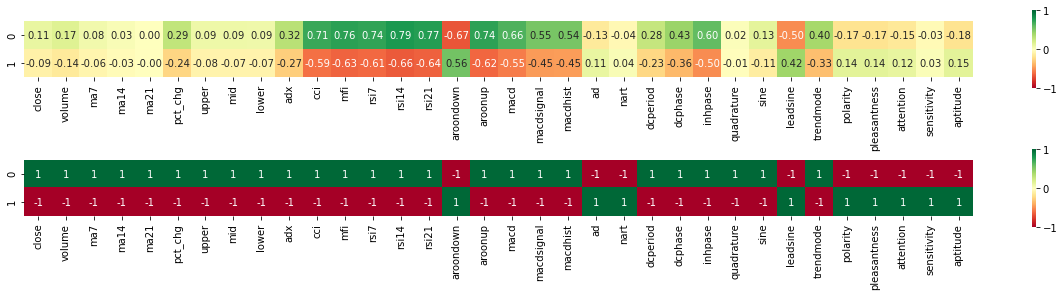

In [10]:
tau, n = best_tau, best_n

X = [x.mean().values for x in weekly(data, tau)]
X = StandardScaler().fit_transform(X)

cluster = Hierarchy(n, method='ward', criterion='maxclust').fit(X)
center = cluster.center
fig, ax = plt.subplots(2, 1, figsize=(17, 4))
ax[0] = sns.heatmap(center,-1, 1, annot=True, square=True, cmap='RdYlGn', fmt='.2f', xticklabels=data.columns, ax=ax[0])
ax[0].tick_params(labelsize=10)
# take the sign of each center.
center = np.sign(center)
ax[1] = sns.heatmap(center,-1, 1, annot=True, square=True, cmap='RdYlGn', fmt='.0f', xticklabels=data.columns, ax=ax[1])
ax[1].tick_params(labelsize=10)
plt.tight_layout()
plt.show()